# Titanic Pipeline Part 2

This script needs to be divided into two sections:
1. Data Exploration and Experimental Scripting
2. Model Definition, Training and Evaluation

In the first half we will just look at the data and derive good strategies from that. This follows an experimental approach and is just used to
have more data insight for the actual model training.


In the second half, we will actually train the model with pipelines and use the information we got from the first part.

**Note**

The sections where tasks from the submission "Part 2" are processed are marked with the following convention (example for Part2, bulletpoint 3):

```python
#region P2.3O

def solution_for_part2_subtask_3():
    print("Some explanations, calculations and super smart thinking.")

#endregion P2.3C


## Section 1

#### Imports

In [ ]:
# Imports
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, OrdinalEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import importlib


from dataprepper import DataPrepper


#### Data Exploration (pre adjustment)

In [1251]:
#region P2.1O

In [ ]:
# read the CSV file and inspect the data
CSV = "./Datasets/titanic_train.csv"
assert Path(CSV).exists(), f"File not found: {CSV}"

data_prepper = DataPrepper("Titanic", "./Datasets/titanic_train.csv", "Survived")
data_prepper.inspect()



=== Titanic: SHAPE ===
(891, 12)

=== Titanic: HEAD ===
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S 

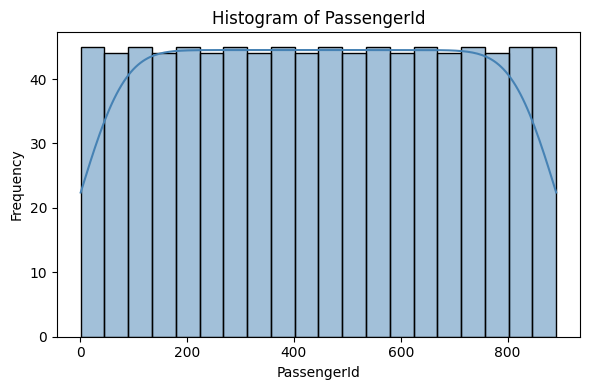

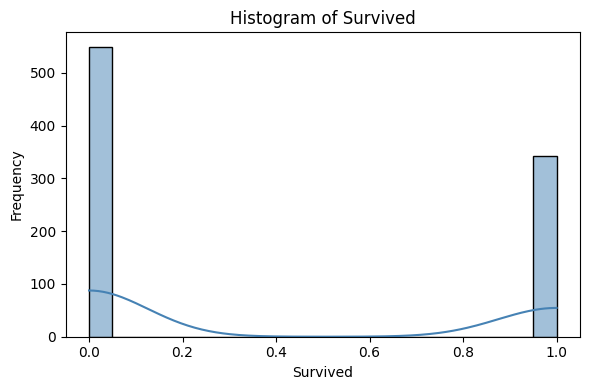

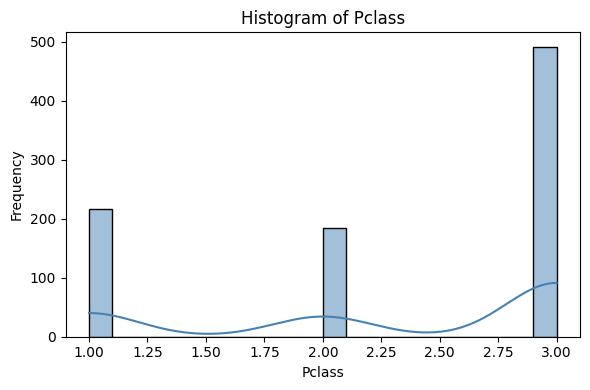

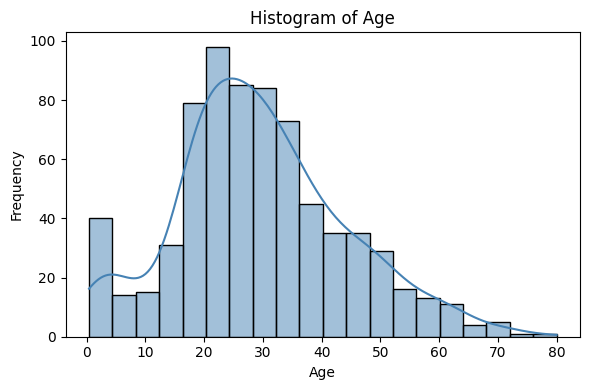

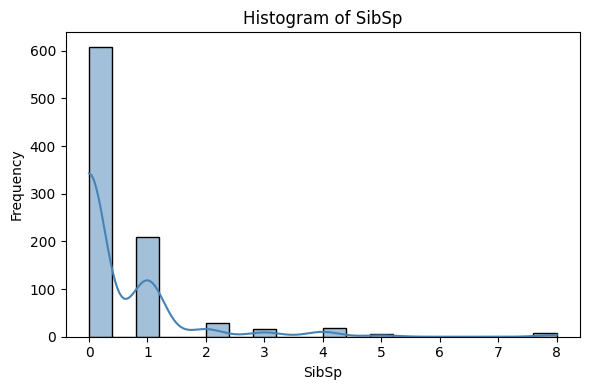

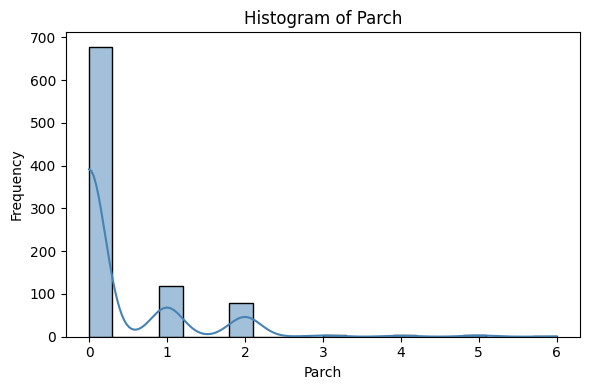

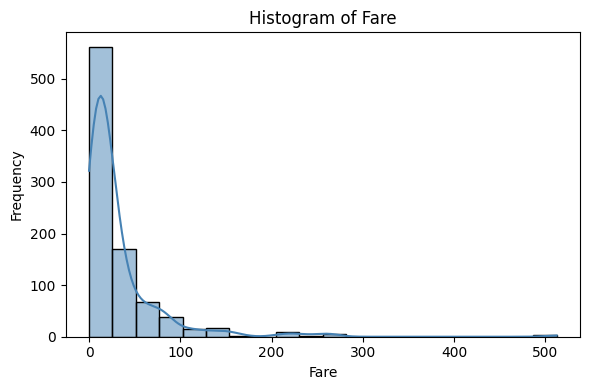

In [1253]:
data_prepper.inspect_histograms(kde=True)

#### Data Preprocessing -- Missing Values

Since only 3 categories have missing values, we will think of strategies to deal with that:

`Age:`
There are a lot of rows effected in this category, so simply dropping the rows with NaN values is not an option.
However, a simple imputer for age is the median value. This value is robust against outliers and as we can see on the histogram for age it seems quite
reliable to use it in this case.

`Embarked`:
Missing values in this category are at a tiny amount. We could simply drop the affected rows and it would not affect the information of the
data to much. BUT, we will figure, that this category itself is of no information anyways. The Titanic sank in the middle of the ocean,
so all passengers that were on board had to embark somewhere, which gives us no information, if they actually survived or not. Well, if one of the
embarkment harbors would have bin "Monte Carlo", we could assume, that more first class passengers boarded here which could affect the prediction
of surviving chances. However, that would be strongly correlated to "Pclass", so the information gain will be still very small.
Long story short, we just fill the missing values with any harbor and drop the whole feature later on.

`Cabin:`
This category cannot be simply dealt with. It consists of Letters (the decks) and numbers (the actual rooms). For the target column, if a passenger
survived or not, it is not of importance, in which exact room the passenger stayed. It is more important on what deck he lived on. So we can
filter the cabin-category in a way, that it only shows the deck, but not the room number. However, this does not solve the problem that there is a huge
amount of data missing (77%). Simply dropping affected rows is not an option due to the amount of affected rows.
As historical data shows, first-class passengers lived on the higher decks, lower classes on lower decks. So at this point we can pose a suspicion:
"Passenger-Class and Cabin(Deck)" are correlated. If that is the case, it would be easier to drop the feature "Cabin", than forcefully impute the missing
values with halfway passing values.


In [1254]:

# Age
_ = data_prepper.missing_median(col="Age")

# Embarkment
_ = data_prepper.missing_forceVal(col="Embarked", value="S")

# Cabin:
# 1. Extract the decks
def get_cabin_deck(df: pd.DataFrame, col: str = "Cabin") -> pd.DataFrame:
    df[col] = df[col].astype(str).str[0].replace("n", np.nan)
    counts = df[col].value_counts(dropna=True).sort_index()
    for deck, n in counts.items():
        print(f"  {deck}: {n}")

    return df

data_prepper.df = get_cabin_deck(df=data_prepper.df)

Replaced 177 numeric NaN values in "Age" with median 28.0.
Replaced 2 NaN values of "Embarked" with S.
  A: 15
  B: 47
  C: 59
  D: 33
  E: 32
  F: 13
  G: 4
  T: 1


**Note:**
Cabin T is very misleading (there was no such low deck on the titanic): https://www.encyclopedia-titanica.org/community/threads/cabin-t.1731/

Removed 687 rows containing NaN values in "Cabin" (204 remain).
Applied Label-Encoding on 'Cabin' (8 unique classes)
Applied Label-Encoding on 'Pclass' (3 unique classes)


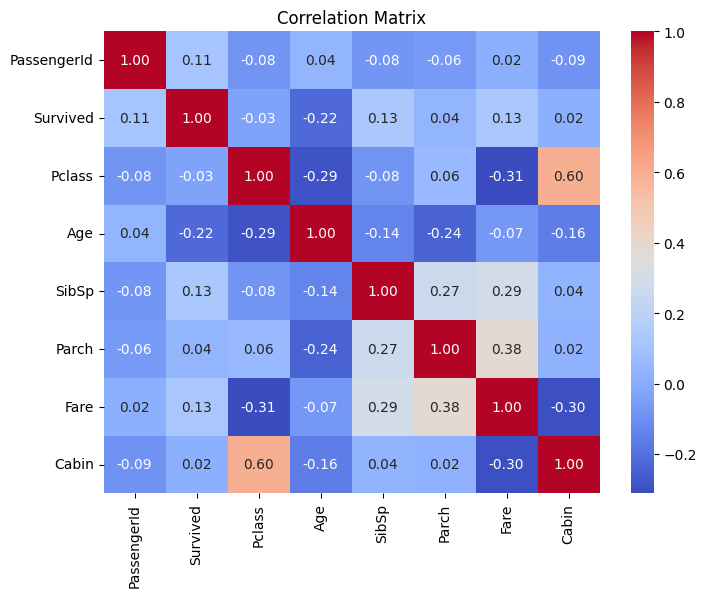

In [1255]:
# 2. Make a copy of the data and check, whether our assumption about the correlation is true
check = data_prepper.df.copy()

dp = DataPrepper(name="Check_For_Correlation", df=check)

# Drop all rows with NaN values in Cabin
dp.missing_kill(col="Cabin")

# Encode the affected categories so we can check for correlation
_ = dp.apply_labelEncoding(col="Cabin")
_ = dp.apply_labelEncoding(col="Pclass")

dp.inspect_correlation()


So in this correlationmatrix we can clearly see, that our assumption was true and Cabin and Pclass are in fact correlated.
Therefore we can mark Cabin as "to be dropped", since it carries the same information gain as Pclass, while Pclass does not have
so many missing values.

#### Data Preprocessing -- Categorical Features (Encoding)

`Sex:`
Since sex is a "binary" feature, so it is either "male" or "female", it is best practice to encode it with "OneHot" Encoding.
The whole data set will only grow by one new feature (we delete "Sex" and add "Male", "Female").

`Embarked:`
Embarked only carries three possible values. So again we will encode it with "OneHot" since it will not enlarge our dataset to much.

`Name:`
Although the name of a passenger is absolutely not relevant for our target feature, we would encode it with "LabelEncoding".
"OneHot" would enlarge the dataset to much, since the most names are unique, "Ordinal" would imply an order, but there is no order to names.
Just a random note: if we would use a linear model, we needed to be cautious with using LabelEncoding, since it can imply an order for linear models.

`Ticket:`
As for names, the ticket number is of no information gain to the target column. Maybe, if the ticket number carries information about the PassengerClass,
that could be used as information. But here again, we would have seen a correlation in the correlation matrix so we assume, that there is no correlation,
encode the category for the moment and drop it later on.

`Cabin:`
As we have shown before, Cabin will be dropped. So it is not necessary to encode it too.
However, for learning purposes we will think about it for a moment.
Since the information carried by cabin is more about the deck, on which the cabin is placed, we
can assume that this category follows an ordinal structure. Therefore, it would be best practice to encode it with an ordinal encoder.
Luckily, the decks are already alphabetically ordered, so we do not have to make complex calculations.

`Pclass:`
We encode Pclass with Ordinal, since we have an ordinal variable in this case (1<2<3).

In [1256]:
# OneHot Encoding
_ = data_prepper.apply_onehot(col="Sex")
_ = data_prepper.apply_onehot(col="Embarked")

# Ordinal [Just splitted for better insight in the correlation matrix]
_ = data_prepper.apply_ordinal(col="Pclass", categories=[[1,2,3]], new_col="Pclass_ord")
_ = data_prepper.apply_onehot(col="Pclass")

# LabelEncoding [Be aware, that this implies a misleading order]
_ = data_prepper.apply_labelEncoding(col="Name")
_ = data_prepper.apply_labelEncoding(col="Ticket")


# Not needed and only raises errors since we have a lot of NaNs
# _ = data_prepper.apply_ordinal(col="Cabin")


Applied One-Hot-Encoding on 'Sex' && created 2 columns
Applied One-Hot-Encoding on 'Embarked' && created 3 columns
Applied Ordinal-Encoding on 'Pclass' → 'Pclass_ord' with categories: [1, 2, 3]
Applied One-Hot-Encoding on 'Pclass' && created 3 columns
Applied Label-Encoding on 'Name' (891 unique classes)
Applied Label-Encoding on 'Ticket' (681 unique classes)


#### Data Preprocessing -- Numerical Features (Scaling)

`PassengerId:`
PasengerId carries the same information as "Name". Both are unique.
Furthermore, as "Pclass" it is more to be used as a categorical feature, than a numerical. It simply is the passengers name encoded with
a "LabelEncoder". Therefore, we will not scale it and use it as a categorical feature too.

`SibSp/Parch/Fare:`
As seen in the histograms, we have a lot of values around zero with some outliers, which indicates a right skewed feature.
There fore we will use the MinMax-Scaler to scale those features to a domain of [0, 1].

`Age:`
The age follows a normal distribution (seen in the histograms), which is why it is best to use the StandardScaler.




In [1257]:
# MinMax-Scaling
_ = data_prepper.apply_minMax(col="SibSp", feature_range=(0,1))
_ = data_prepper.apply_minMax(col="Parch", feature_range=(0,1))
_ = data_prepper.apply_minMax(col="Fare", feature_range=(0,1))

# Standard
_ = data_prepper.apply_standard(col="Age")

Scaled 'SibSp' with MinMaxScaler (range=(0, 1))
Scaled 'Parch' with MinMaxScaler (range=(0, 1))
Scaled 'Fare' with MinMaxScaler (range=(0, 1))
Scaled 'Age' with StandardScaler


#### Data Exploration (after adjustment)

In [1258]:

data_prepper.inspect()


=== Titanic: SHAPE ===
(891, 18)

=== Titanic: HEAD ===
   PassengerId  Survived  Name       Age  SibSp  Parch  Ticket      Fare  \
0            1         0   108 -0.565736  0.125    0.0     523  0.014151   
1            2         1   190  0.663861  0.125    0.0     596  0.139136   
2            3         1   353 -0.258337  0.000    0.0     669  0.015469   
3            4         1   272  0.433312  0.125    0.0      49  0.103644   
4            5         0    15  0.433312  0.000    0.0     472  0.015713   

  Cabin  Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  Pclass_ord  \
0   NaN       False      True       False       False        True         2.0   
1     C        True     False        True       False       False         0.0   
2   NaN        True     False       False       False        True         2.0   
3     C        True     False       False       False        True         0.0   
4   NaN       False      True       False       False        True         2.0   


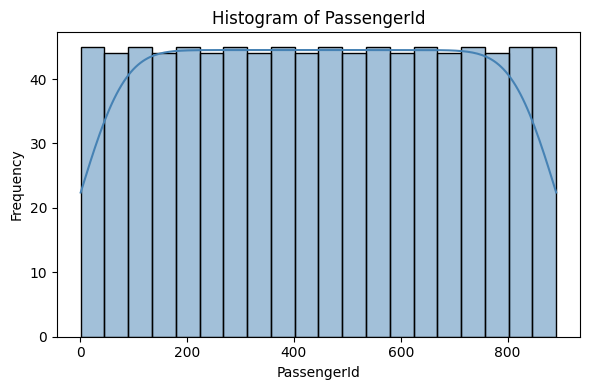

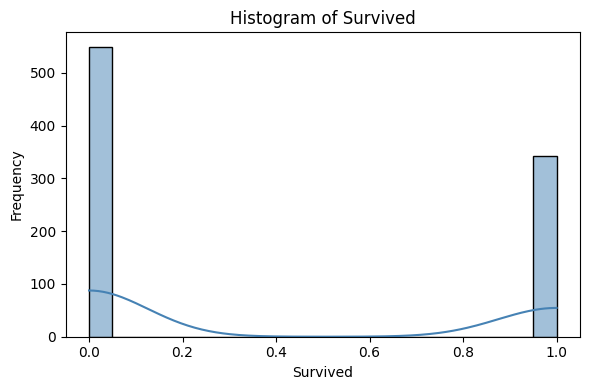

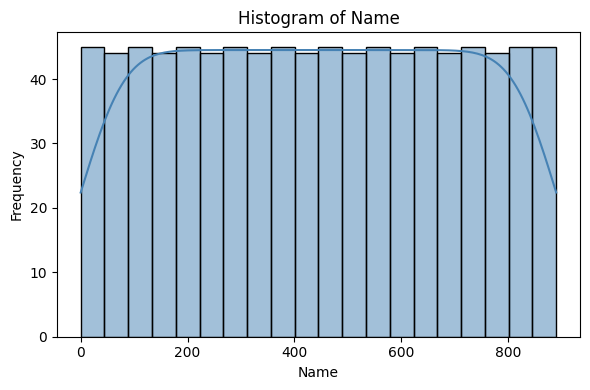

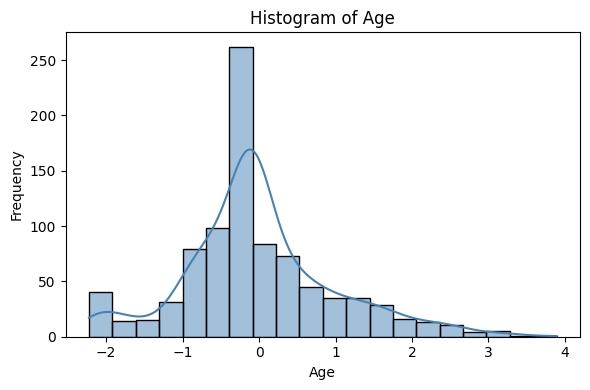

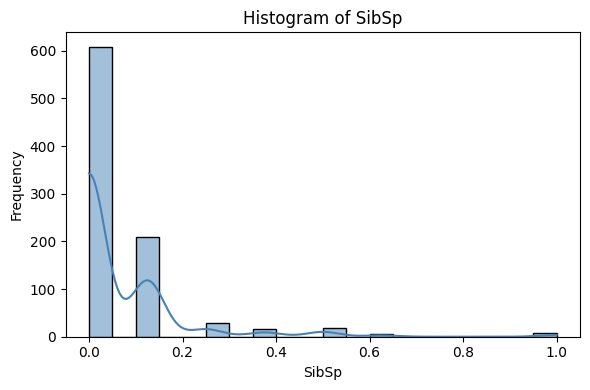

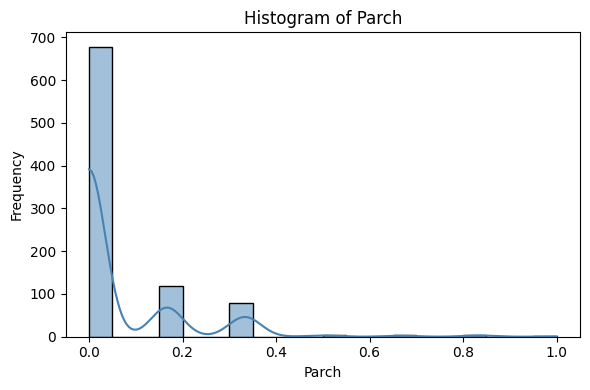

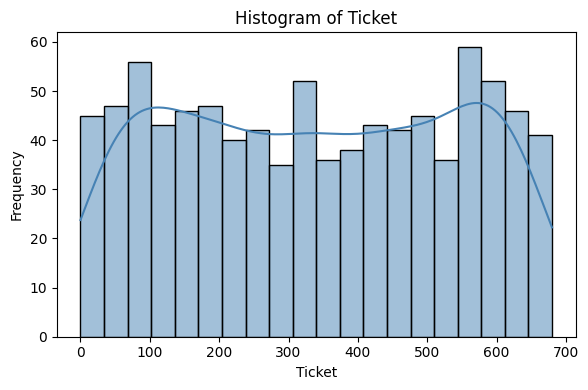

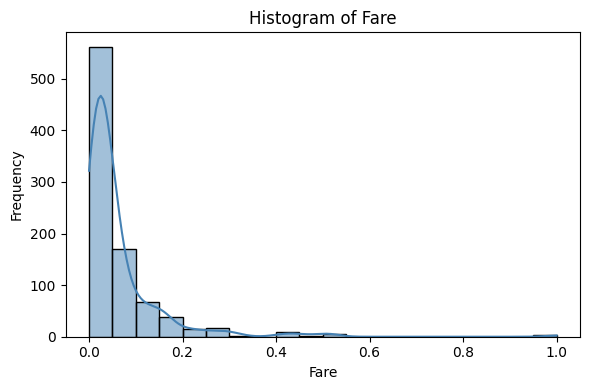

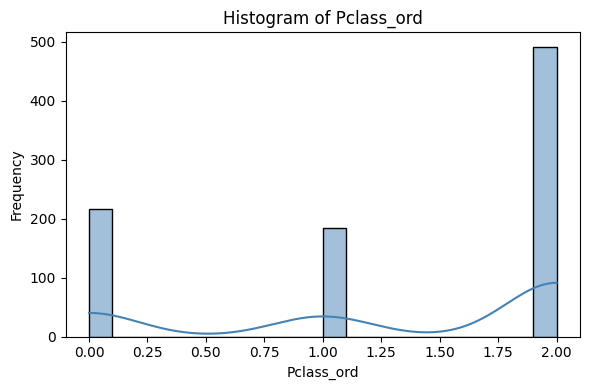

In [1259]:
data_prepper.inspect_histograms(kde=True)

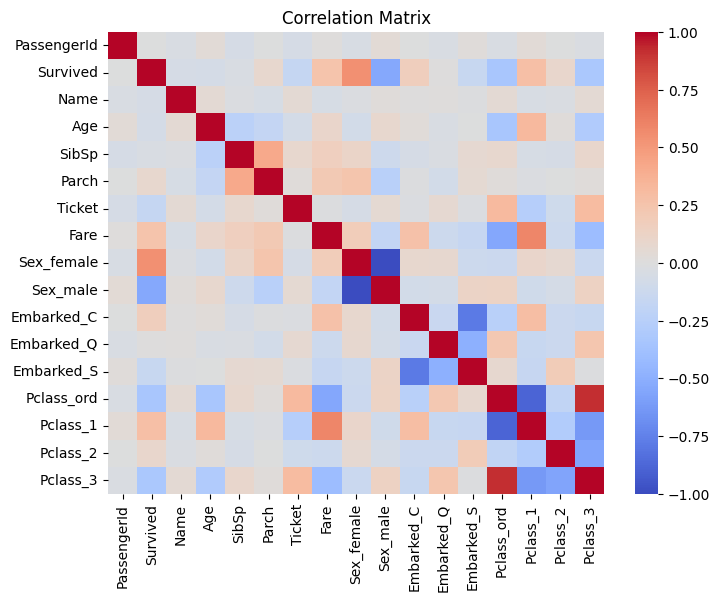

In [1260]:
data_prepper.inspect_correlation(annotate=False)

In [1261]:
#endregion P2.1C

## Section 2

So with the newly gained information from "Part 1", we can decide for the features, scalers and encoders we want to use.
When it comes to the feature selection, we have to keep in mind, to decide with a historical background.
For example: Today, the sex would not play such a big role in deciding whether a passenger survives or not. Back then, it definitely did.

#### Data Loading

In [ ]:
CSV_TRAIN = "./Datasets/titanic_train.csv"
CSV_TEST = "./Datasets/titanic_test.csv"
assert Path(CSV_TRAIN).exists(), f"File not found: {CSV_TRAIN}"
assert Path(CSV_TEST).exists(), f"File not found: {CSV_TEST}"

train_set = pd.read_csv(CSV_TRAIN)
test_set = pd.read_csv(CSV_TEST)


#### Feature Selection

##### <u>Target Feature:</u>

`Survived:`

The goal of out model is to decide, whether a passenger is more likely to survive the Titanic than another, based on information about the specific
passenger.
Hence, deciding which features to use should support this task.

##### <u>Features to keep:</u>

`Pclass:`

It is quite obvious, that passengers from a higher class are more likely to survive. That has multiple reasons.
For example, passengers from a higher class were located closer to the life boats, which were located on the boat deck (highest level).
Passengers from the lower (third class) decks, were less likely to reach the life boats in time. Moreover, back then people from a higher
class simply got prioritized over lower class citizen.

`Sex:`

The well known saying "Women and Children first." was quite present back in 1912. So the chance of surviving the Titanic was significantly higher
when you were a woman (or a child). Hence, we should definitely use "Sex" in out model-train data, since it carries a high information gain.
That can also be seen in the earlier correlation matrix, where survival and sex are correlated more than other values.

`Age:`

As partly mentioned in "Sex", children had a higher chance of survival than elders. Therefore it is quite obvious to also include the
"Age" feature in our model construction.


`Fare:`

In the correlation matrix we can see, that fare and survival are a bit correlated. So it is clever to include in our calculations.
Other than ticket (which is also correlated but not included), fare gives us information about the class and financial standing of the passenger,
which could affect his chance of survival. Hence, we include it in the model build process.



##### <u>Features to drop:</u>

`Ticket:`

As we have clarified before, the "ticket" feature does not contain any extra information we could use, and if so, it is most likely to correlate
with ticket fare or pclass. Hence this case, we can drop the feature, because other features carry the same and even better information gain.

`Name:`

The name also carries no real information for predicting a survival. The name only contains information from a present point of view
(we could simply look up the name in a public database and check if the person survived, which would fail our cause), but looking it through
the lenses of 1912, any name could belong to any person, which is why we can drop it.

`Cabin:`

As shown before, cabin has two reasons for being dropped. First of all, it has the highest number of missing values of the whole dataset.
Furthermore, it correlates with Pclass. Hence, to prevent overfitting we drop "cabin" (it carries the same information gain as Pclass and
it would be a huge effort filling missing values with reasonable values).

`PassengerId:`

The PassengerId simply is a categorical feature, which carries the same information as "Name": None.
Any passenger could be assigned any PassengerId, so as for name we can drop this feature two.

`Embarked:`

As already discussed in "Part 1", the harbor of embarkment carries no information about the survival chance. Maybe it would, if one of the
harbors is known for embarking more higher class passengers (e.g. Monte Carlo), than others. But that information would then be correlated to
the "Pclass" or "Fare" so we can easily drop this feature without losing information.
Moreover, if the Titanic sank between two embarkment harbors, then we would also have kind of an information gain, because all passengers
embarking from harbors not yet entered would have a 100% chance of survival.
Long story short, we can drop it since it has no value for the prediction.


##### <u>To be discussed further:</u>

`SibSp:`

This category gives us insight about whether a person traveled with sibling or a spouse. We found good reasons for including and excluding this feature,
which are to be discussed further. But in order to guarantee a pure model, based on real knowledge, we exclude these features from the model build
process.

Reasons for including this feature are, that maybe husbands, who traveled with their wives had a higher chance of also getting a seat in
a life boat, when their wifes got a seat. So in this case, having a wife on board would be an advantage to survive.
However, from historical data we know, that no exceptions were made and men of any kind had a hard time finding a life boat that would carry them.
So in this case, the chance of survival for any man, with or without wife, would be the same.
The argument for siblings follows the same logic.

`Parch:`

The logic for this category is strongly related to the one in "SibSp". So if you had higher chances with or without a Parent/Child is hard to say.
From a present point of view it makes total sense to assume, that passengers who are aboard with their children have a higher chance of survival,
due to the thought: "Oh no, we can not separate children from their parents." But yet again, from historical data we know that that happened.
Hence, drawing a clear solution, if this feature affects the chance of survival is not directly possible, which is why we excluded it.
To guarantee a pure model based on hard knowledge.


In [1285]:
target = "Survived"

feature_num_all = ["Age", "Fare"]
feature_num_age = ["Age"]
feature_num_fare = ["Fare"]

feature_cat_all = ["Sex", "Pclass"]
feature_cat_pclass = ["Pclass"]
feature_cat_sex = ["Sex"]

features = feature_num_age + feature_num_fare + feature_cat_pclass + feature_cat_sex

X = train_set[features].copy()
y = train_set[target].astype(int).copy()

# From Part 1 we already know, that age has missing values and how to deal with it.
print("Missing values per column:\n", X.isna().sum(), "\n")

Missing values per column:
 Age       177
Fare        0
Pclass      0
Sex         0
dtype: int64 



#### Preprocessing with `ColumnTransformer` [KeyHint: Scaling is useless for trees...]

**Numeric-Features:**
- Impute with median (only "Age" is affected in training)
- "Age" follows normal distribution -> use StandardScaler
- "Fare" is skewed to the right -> use MinMaxScaler

**Categorical-Features:**
- Impute both with most-frequent
    * can be misleading for "Pclass", since there were more third-class passengers than first-class passengers, but since the dataset has no
    missing values for this feature, it is sufficient to use this strategy for the moment
- OneHot Encoding: Used for "Sex" since it is a binary attribute and does not enlarge the dataset too much.
- Pclass will be encoded with ordinal since it is an ordinal variable (1<2<3).

In [1235]:
#region P2.2O

In [ ]:
# Numerical Features
num_pipeA = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

num_pipeF = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", MinMaxScaler())
])


# Categorical
cat_pipeP = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ordinal", OrdinalEncoder(categories=[[1,2,3]], handle_unknown="use_encoded_value", unknown_value=-1))
])

cat_pipeS = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])


# Putting it all together
preprocess = ColumnTransformer(
    transformers=[
        ("age", num_pipeF, feature_num_age),
        ("fare", num_pipeF, feature_num_fare),
        ("sex", cat_pipeS, feature_cat_sex),
        ("pclass", cat_pipeP, feature_cat_pclass)
    ]
)

In [1237]:
#endregion P2.2C

#### Full Pipeline

In [1238]:
#region P2.3O

In [1293]:
rf = RandomForestClassifier(
    n_estimators=400,
    random_state=42,
    n_jobs=-1
)

pipe = Pipeline(steps=[
    ("pre", preprocess),
    ("clf", rf)
])

In [1240]:
#endregion P2.3C

#### Split and Training

In [1241]:
#region P2.4O

In [1294]:
X = train_set.drop(columns="Survived")
y = train_set["Survived"]

X_trainT, X_test, y_trainT, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

pipe.fit(X_trainT, y_trainT)

,steps,"[('pre', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('age', ...), ('fare', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


#### Test

In [1295]:
y_pred = pipe.predict(X_test)

In [1244]:
#endregion P2.4C

#### Evaluation

In [1245]:
#region P2.5O

##### Interpretation

So as we can see below, our chosen features provide an overall accuracy of ~83.24%

After also evaluating Precision, Recall, and F1-Score, we can accept this accuracy as being representatively
important for describing the models overall performance.

The confusion matrix does not need to be evaluated further, since the given values are derived from the data shown in it. It is just plotted for visual
understanding.

              precision    recall  f1-score   support

           0       0.85      0.88      0.87       110
           1       0.80      0.75      0.78        69

    accuracy                           0.83       179
   macro avg       0.83      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179

Accuracy: 0.8324022346368715


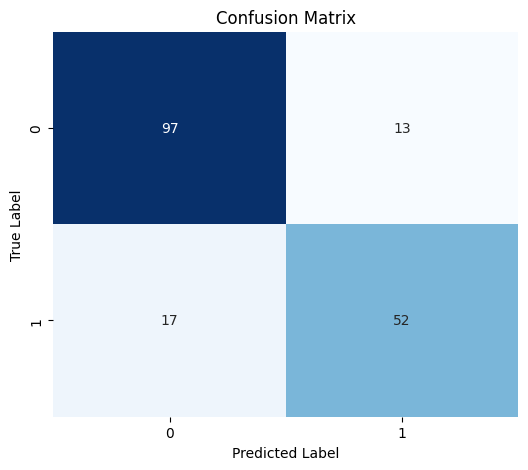

In [1296]:
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

DataPrepper.evaluate_confusion(y_test=y_test, y_pred=y_pred)

In [1247]:
#endregion P2.5C

#### Feature Importance

In [1248]:
#region P2.6O

##### Interpretation

For evaluating the feature importance, we simply evaluate, how strong single features are correlated to the target feature.
So the "Top Feature Importances" and the "Correlation Matrix" insight are intercepting each other. We can determine that by inspecting the order of importance:
 - the higher the correlation of a feature to the target, the higher it rises in the Importance-Bar Plot

So explaining the evaluation with raw words:

    - Features "fare" and "sex" are most important for deciding whether a person survives or not.
    - Features "age" and "Pclass" are most important for deciding whether a person dies or not.

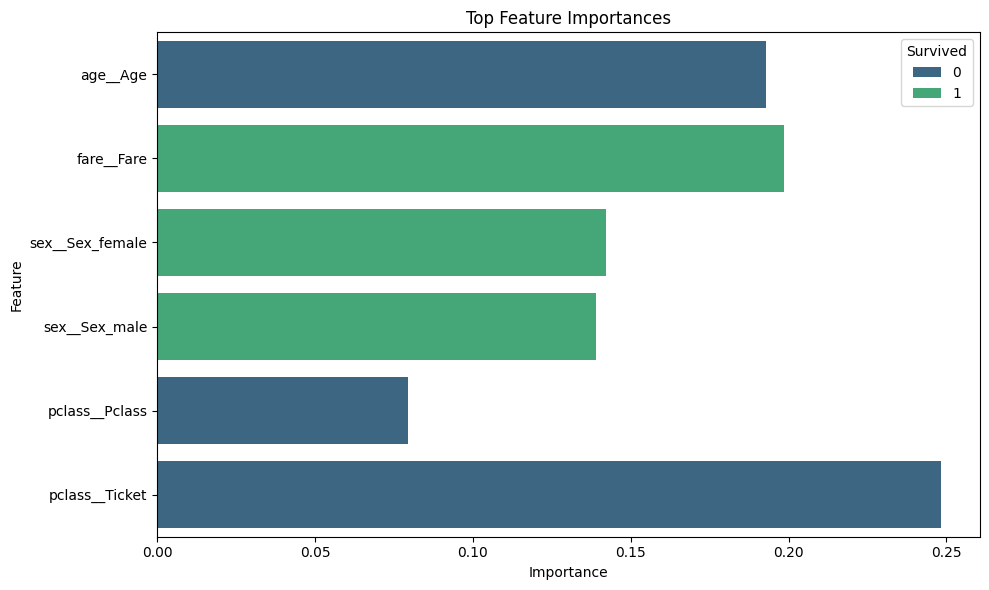

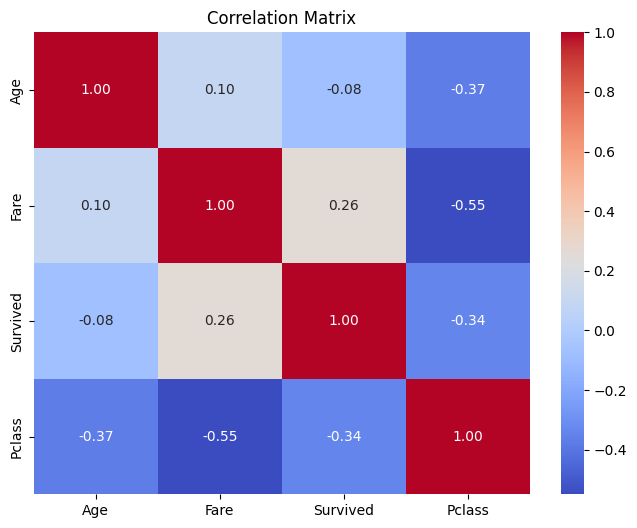

In [1278]:
DataPrepper.evaluate_importance(pipe=pipe, steps=["pre", "clf"], y=y)

data_prepper.inspect_correlation(df=train_set, categories=["Age", "Fare", "Survived", "Pclass"])

In [1093]:
#endregion P2.6C

#### Ethical Reflection

In [1102]:
#region P2.7O

##### Ethical Reflection

As we have shown in the evaluation, "Sex" and "Pclass" are both very important features for predicting the survival chances of an individual person, since it favors more wealthy people and women.
Yet, from a present point of view it is highly unlikely, that these factors would play a large role if such a tragedy would happen in the 21st century.
So here we see, that a historical bias has been introduced, leading to a bias-based outcome if applied on modern datasets. However, for predicting the specific survival chance on the Titanic (or any tragedy in that time period), using these features is still most effective.
Hence, using such data for modern predictions or use cases would amplify historical inequities, forcing us to adjust the data in a way it is usable
fairly and balanced for any kind of person.

For this we would have to raze Sex and Pclass and either transform it, or delete it completely from the dataset.
- We could simply remove or downweight sensitive features like Sex or Pclass, so that other features will be treated more important, reducing the underlying bias.
- We also could implement a function, marking when a decision was drawn mainly using one of those features. Therefore it would be nearly impossible to confuse historical analysis with predictive and relevant decision making.

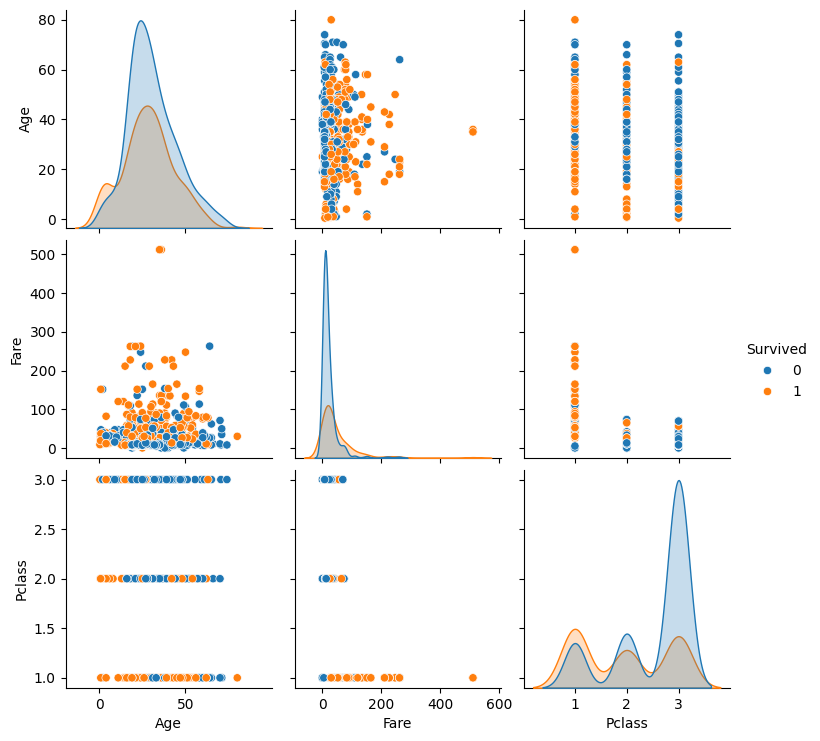

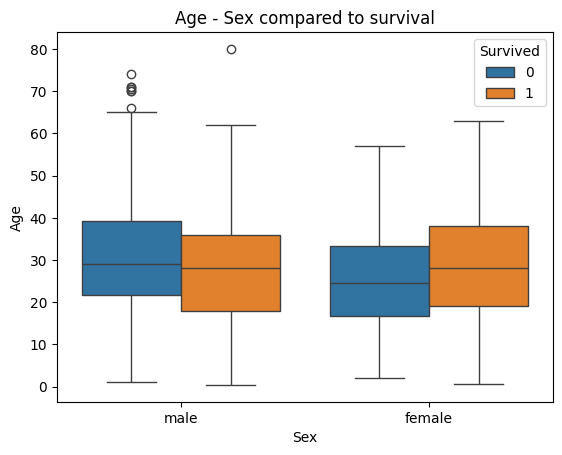

In [ ]:
DataPrepper.evaluate_relationships(train_set=train_set, features=["Age", "Fare", "Pclass"], hue="Survived")

DataPrepper.inspect_boxplot(data=train_set, x="Sex", y="Age", hue="Survived", title="Age - Sex compared to survival")

In [1103]:
#endregion P2.7O